# Решение задачи uplift моделирования

In [1]:
import joblib
from IPython.display import display

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklift.datasets import fetch_megafon

from sklift.models import SoloModel, TwoModels, ClassTransformationReg
from causalml.inference.tree import UpliftRandomForestClassifier
from causalml.inference.meta import BaseXClassifier, BaseRClassifier

from sklift.metrics import qini_auc_score, uplift_at_k, uplift_by_percentile, uplift_auc_score
from sklift.viz import plot_uplift_curve

import optuna
import shap

from BorutaShap import BorutaShap

from lightgbm import LGBMClassifier, LGBMRegressor

%matplotlib inline

E:\MyProjects\venvs\uplift\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# SEED

In [2]:
import random
SEED = 777

np.random.seed(SEED)
random.seed(SEED)

# Load the data

In [3]:
data, target, treatment = fetch_megafon(return_X_y_t=True)

In [4]:
data

,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,...,X_41,X_42,X_43,X_44,X_45,X_46,X_47,X_48,X_49,X_50
0,39.396577,-0.186548,19.524505,21.250208,55.291264,182.966712,-5.385606,144.573379,-12.534344,-58.279429,...,90.877638,134.363458,-213.584582,-2.092461,-93.973258,-0.155597,-312.130733,44.798182,-125.682413,16.231365
1,38.987694,0.819522,-42.064512,-48.270949,-33.171257,179.459341,-87.151810,-162.693257,20.651652,181.635081,...,-183.840746,72.864779,559.783584,1.142391,80.037124,-1.216185,-111.473936,-127.737977,-117.501171,10.732234
2,-16.693093,1.844558,-8.615192,-18.818740,-22.271188,-116.290369,-63.816746,-38.340763,24.968496,-136.340629,...,-203.637766,2.480242,96.998504,1.100962,-33.275159,0.920926,-679.492242,-91.009397,-18.173358,14.367636
3,-72.040154,-0.226921,39.802607,16.441262,-1.112509,68.128008,23.073147,4.688858,-49.383641,-91.866107,...,172.906875,83.951551,-323.642557,-0.369182,93.221948,-1.962380,-442.466684,-22.298302,-75.916603,11.634299
4,18.296973,0.996437,24.465307,-34.151971,24.623458,-155.455558,-12.159787,26.705778,105.864805,258.607252,...,125.577535,-208.531112,118.902324,-0.808578,-117.497906,1.770635,627.395611,122.019189,194.091195,-11.883858
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
599995,33.031482,0.584463,-25.546737,-35.129322,6.603716,-90.384229,-44.399223,71.343628,26.439937,125.557722,...,-183.820274,-167.259176,531.793092,-2.307605,-48.648490,0.763070,152.501250,-49.190995,149.292732,-15.031430
599996,-24.469552,1.175070,35.936859,19.577711,81.505532,-164.141125,-8.221423,38.864814,-2.410108,71.748724,...,103.792521,-87.706751,-230.298393,0.267790,-56.102467,-1.007702,-69.854583,187.924882,109.642972,25.022399
599997,-57.592800,1.033326,-20.608920,87.116236,-27.894756,120.864975,40.592090,-34.134983,-26.821810,-236.479871,...,-97.993743,170.942462,299.211339,-0.930181,168.767350,-0.004762,-249.073528,-265.077308,-110.317964,-11.892925
599998,-16.371510,-0.876885,-1.483559,32.407631,-57.148865,92.559125,-21.464004,-110.615734,58.100487,-131.522851,...,-17.409713,108.897052,223.509177,-0.832695,5.545312,0.659149,-156.605507,-41.757924,-89.330302,-22.886739


In [5]:
data.shape

(600000, 50)

In [6]:
target.value_counts(normalize=True)

conversion
0    0.79581
1    0.20419
Name: proportion, dtype: float64

In [7]:
treatment.value_counts(normalize=True)

treatment_group
treatment    0.500613
control      0.499387
Name: proportion, dtype: float64

In [8]:
train_idx, test_idx = train_test_split(data.index, test_size=0.2, random_state=SEED)
val_idx, test_idx = train_test_split(test_idx, test_size=0.5, random_state=SEED)

In [9]:
len(train_idx), len(val_idx), len(test_idx)

(480000, 60000, 60000)

In [10]:
all_features = data.columns.tolist()
treatment_col = 'treatment'
target_col = 'target'

data[treatment_col] = treatment.map({'treatment': 1, 'control': 0})
data[target_col] = target

# Dataset exploration

In [11]:
# ATE
stats = data.loc[train_idx].groupby(treatment_col, as_index=False)[target_col].mean()
stats[stats[treatment_col] == 1][target_col].values - stats[stats[treatment_col] == 0][target_col].values

array([0.04999126])

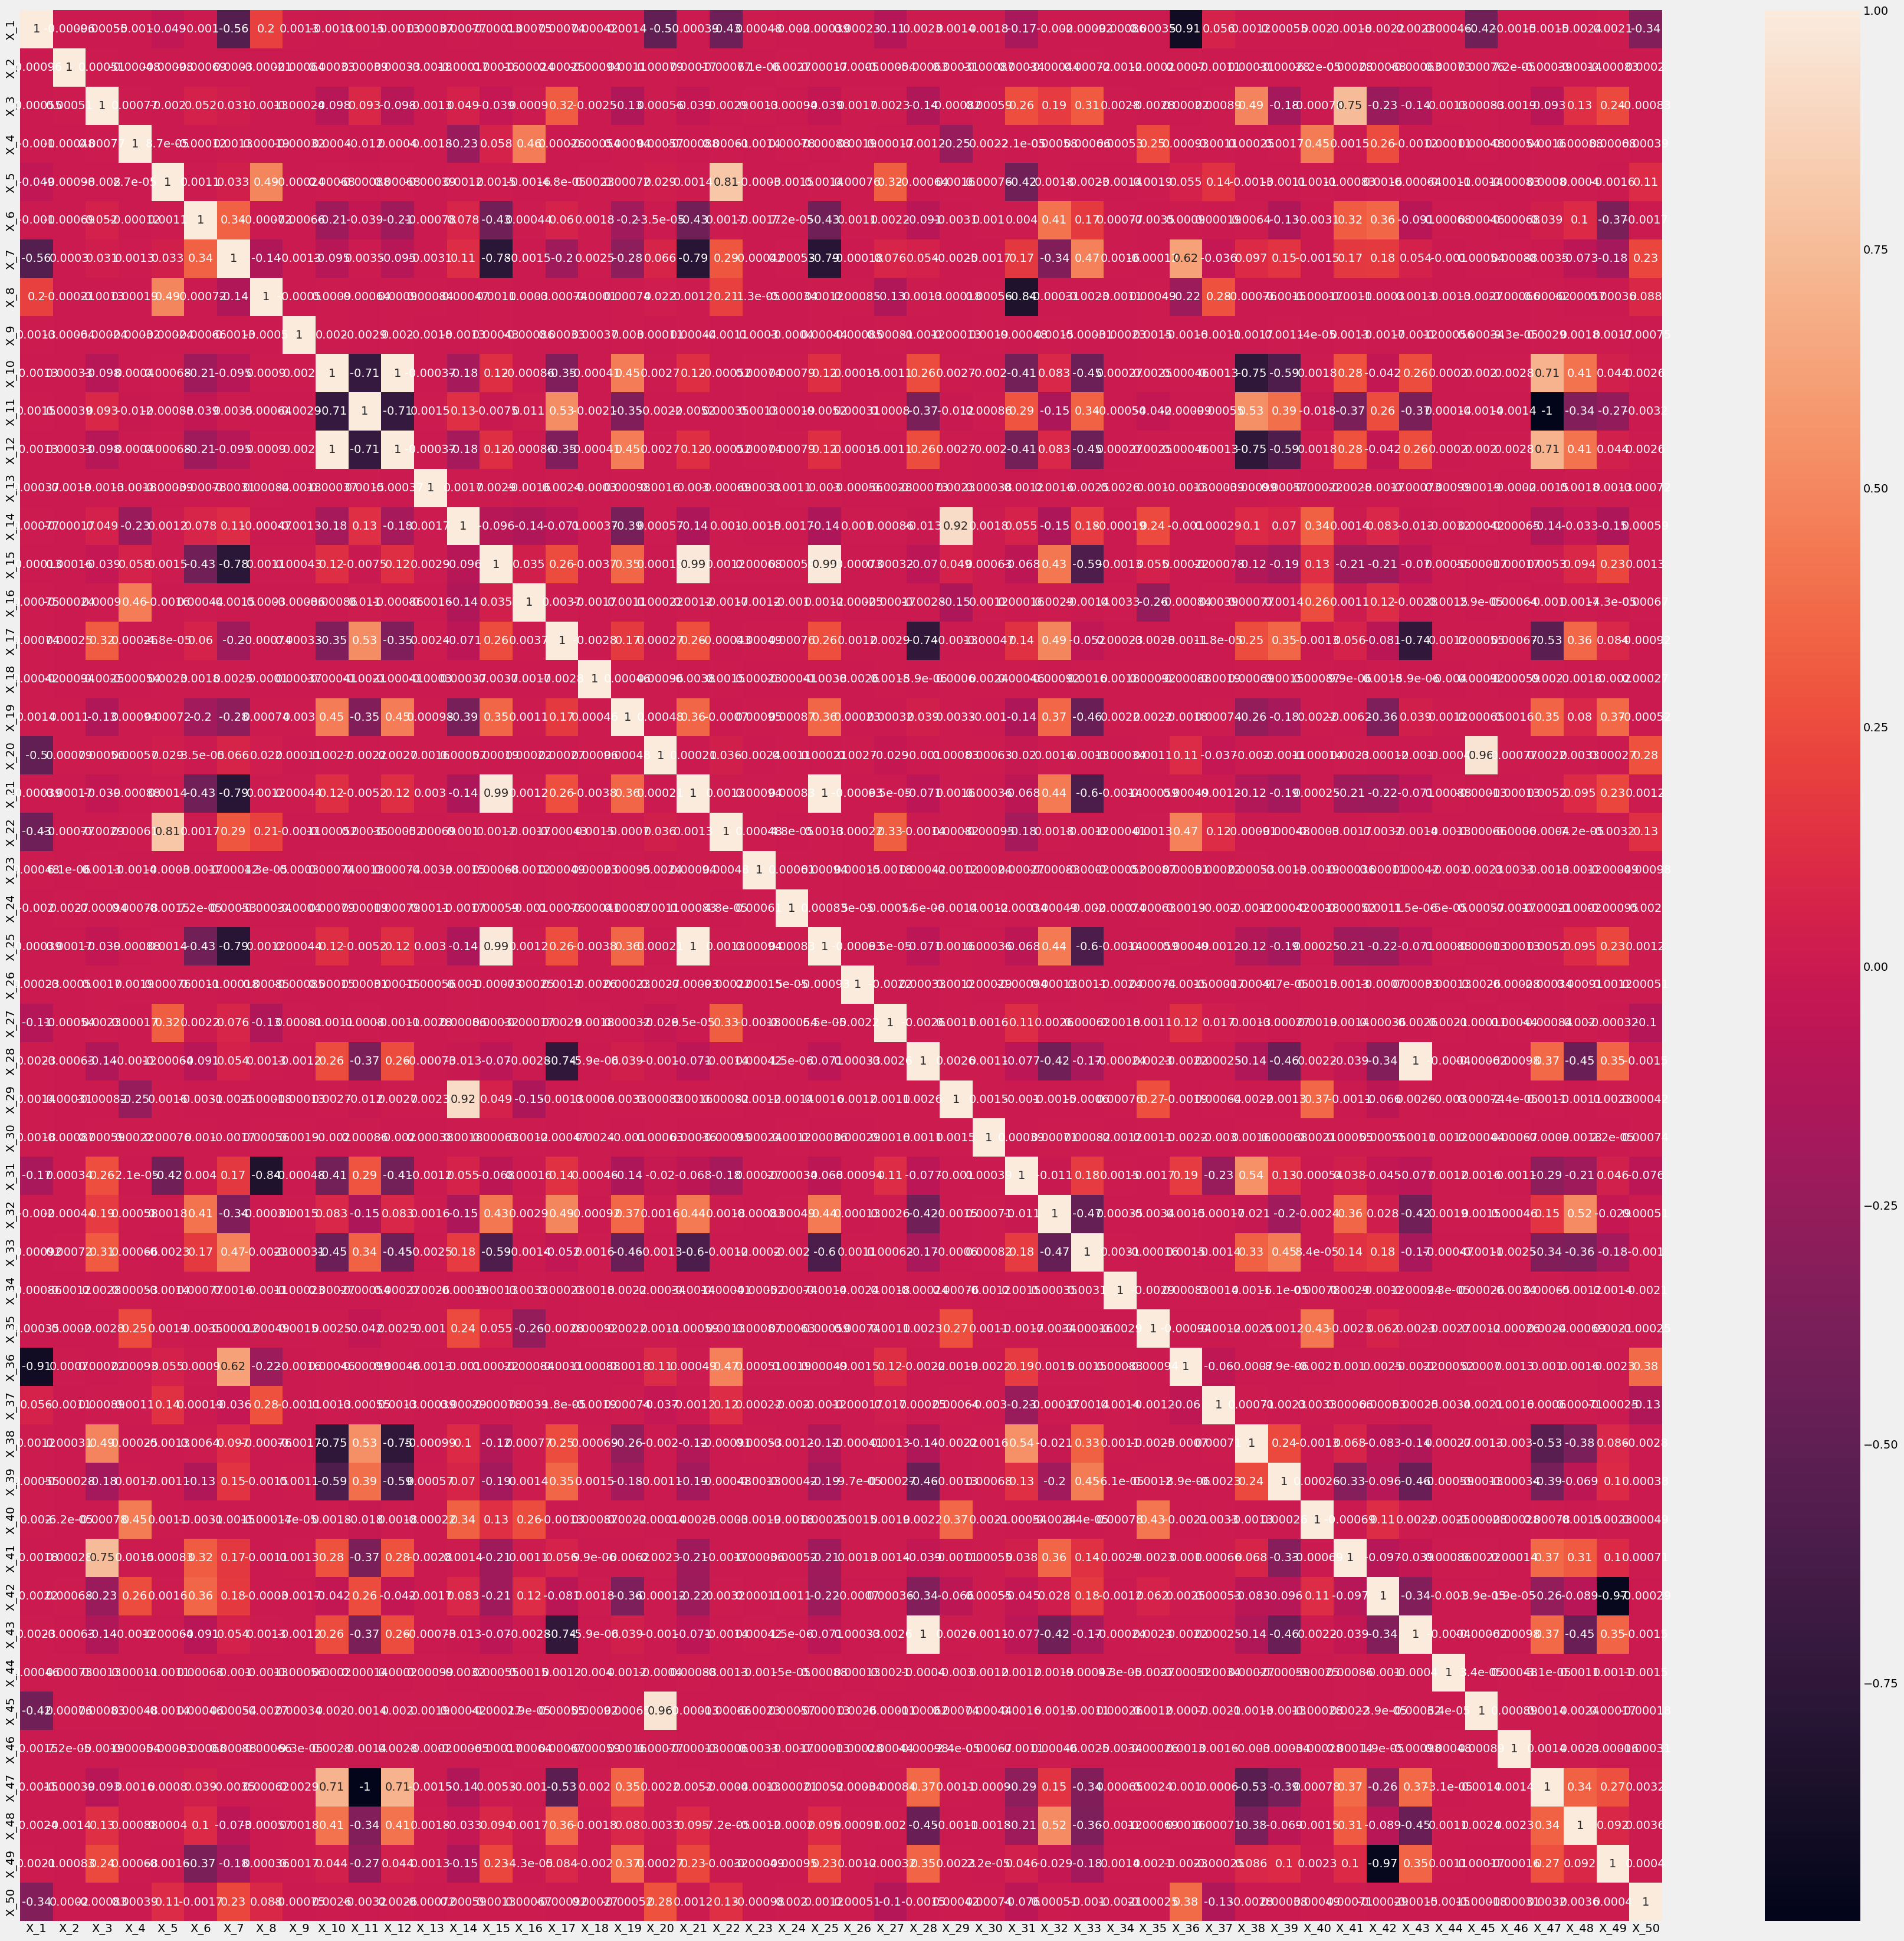

In [12]:
# имеются абсолютно скоррелированные признаки

plt.figure(figsize=(40, 40))
sns.heatmap(data.loc[train_idx, all_features].corr(), annot=True);

In [13]:
# for feature in data.columns:
#     plt.hist(data.loc[train_idx, :][feature], bins=50)
#     plt.pause(0.01);

In [14]:
# все признаки вещественные, ~нормально распределенные

In [15]:
data.loc[train_idx, all_features].describe()

,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,...,X_41,X_42,X_43,X_44,X_45,X_46,X_47,X_48,X_49,X_50
count,480000.000000,480000.000000,480000.000000,480000.000000,480000.000000,480000.000000,480000.000000,480000.000000,480000.000000,480000.000000,...,480000.000000,480000.000000,480000.000000,480000.000000,480000.000000,480000.000000,480000.000000,480000.000000,480000.000000,480000.000000
mean,-3.712086,0.000416,0.375713,-1.008294,3.387393,-6.508972,-2.339737,-6.449409,-0.009596,-1.635282,...,6.938802,-6.695390,8.572287,0.001341,-0.012535,0.000645,-22.125262,-5.859948,6.304576,-1.169728
std,54.860554,0.999492,31.820166,45.323442,53.408085,140.882308,59.794598,74.865170,44.927267,199.384270,...,163.806322,136.943402,262.862096,1.000977,71.585235,1.000170,500.380240,130.895188,141.120999,21.356097
min,-263.319447,-4.372119,-148.870768,-244.446728,-302.574049,-683.126343,-322.731683,-506.202937,-218.466369,-920.347783,...,-810.842593,-633.575178,-1345.838757,-4.748124,-360.713742,-4.512852,-2506.960013,-687.526201,-702.184241,-98.094323
25%,-40.635602,-0.673451,-20.753382,-30.646147,-31.828147,-101.102211,-42.386029,-54.914834,-30.294277,-134.596444,...,-102.515620,-98.883107,-167.430415,-0.673967,-48.307374,-0.674255,-356.713892,-93.294908,-88.640976,-15.565261
50%,-3.915829,0.001087,0.389068,-0.552686,3.770873,-6.474199,-2.342579,-6.480270,-0.025639,-1.591888,...,7.215719,-7.006661,8.880759,0.001215,0.036673,-0.001472,-20.764767,-5.817387,6.522556,-1.206405
75%,33.192497,0.673488,21.503315,29.052710,39.018465,88.046149,37.619312,41.962071,30.229845,130.927555,...,116.829050,85.444318,185.288832,0.676424,48.172537,0.675959,312.775411,81.597777,101.522375,13.243943
max,250.812280,5.062006,170.053291,229.386149,284.915947,656.482242,293.909622,550.525780,199.668464,1251.776972,...,867.086690,689.626208,1408.621638,4.727996,384.665348,5.086304,2534.503855,581.201519,630.727101,112.233293


In [16]:
data.loc[train_idx, :].info()

<class 'pandas.core.frame.DataFrame'>
Index: 480000 entries, 364934 to 325735
Data columns (total 52 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   X_1        480000 non-null  float64
 1   X_2        480000 non-null  float64
 2   X_3        480000 non-null  float64
 3   X_4        480000 non-null  float64
 4   X_5        480000 non-null  float64
 5   X_6        480000 non-null  float64
 6   X_7        480000 non-null  float64
 7   X_8        480000 non-null  float64
 8   X_9        480000 non-null  float64
 9   X_10       480000 non-null  float64
 10  X_11       480000 non-null  float64
 11  X_12       480000 non-null  float64
 12  X_13       480000 non-null  float64
 13  X_14       480000 non-null  float64
 14  X_15       480000 non-null  float64
 15  X_16       480000 non-null  float64
 16  X_17       480000 non-null  float64
 17  X_18       480000 non-null  float64
 18  X_19       480000 non-null  float64
 19  X_20       480000 non-n

# Feature Selection

In [17]:
# Отбирать признаки будем классическим способом, отдельно для treatment и отдельно на control, используя borutashap

In [18]:
# accepted_treatment = []
# rejected_treatment = []
# tentative_treatment = []

# accepted_control = []
# rejected_control = []
# tentative_control = []

# pair = []
# for trmnt_flg in ['treatment', 'control']:
#     fs_boruta = BorutaShap(
#     model=LGBMClassifier(max_depth=5, n_estimators=500, learning_rate=0.05, verbose=-100, n_jobs=-1),
#     importance_measure='shap',
#     classification=True)

#     fs_boruta.fit(
#         X=data.loc[train_idx][treatment.loc[train_idx] == trmnt_flg],
#         y=target.loc[train_idx][treatment.loc[train_idx] == trmnt_flg],
#         n_trials=50,
#         random_state=SEED)

#     if trmnt_flg == 'treatment':
#         accepted_treatment.extend(fs_boruta.accepted)
#         rejected_treatment.extend(fs_boruta.rejected)
#         tentative_treatment.extend(fs_boruta.tentative)
#     else:
#         accepted_control.extend(fs_boruta.accepted)
#         rejected_control.extend(fs_boruta.rejected)
#         tentative_control.extend(fs_boruta.tentative)

# joblib.dump(accepted_treatment, './cache/accepted_treatment.pkl')
# joblib.dump(rejected_treatment, './cache/rejected_treatment.pkl')
# joblib.dump(tentative_treatment, './cache/tentative_treatment.pkl')

# joblib.dump(accepted_control, './cache/accepted_control.pkl')
# joblib.dump(rejected_control, './cache/rejected_control.pkl')
# joblib.dump(tentative_control, './cache/tentative_control.pkl')

accepted_treatment = joblib.load('./cache/accepted_treatment.pkl')
rejected_treatment = joblib.load('./cache/rejected_treatment.pkl')
tentative_treatment = joblib.load('./cache/tentative_treatment.pkl')

accepted_control = joblib.load('./cache/accepted_control.pkl')
rejected_control = joblib.load('./cache/rejected_control.pkl')
tentative_control = joblib.load('./cache/tentative_control.pkl')

In [19]:
selected_features = sorted(list(set(accepted_treatment + accepted_control + tentative_treatment + tentative_control)))
len(selected_features)

34

# Modeling

In [20]:
overall_results = {}

In [21]:
from functools import partial

def get_metrics_from_results(
    results,
    df_test,
    y_name,
    treatment_key,
    control_name='control',
    treatment_name='treatment'
):
    metrics = {}
    
    for method, preds in results.items():
        metrics[method] = {}
        for name, metric in zip(
            ['uplift_at_10', 'uplift_at_30', 'qini', 'auuc'],
            [
                partial(uplift_at_k, k=0.1, strategy='overall'),
                partial(uplift_at_k, k=0.3, strategy='overall'),
                qini_auc_score,
                uplift_auc_score
            ]):
            metrics[method][name] = metric(
                y_true=df_test[y_name].values,
                uplift=preds.ravel(),
                treatment=df_test[treatment_key].values
            )
    return pd.DataFrame(metrics)

def fact_predict(target, uplift, treatment, n_bins=10):
    # запишем результаты (таргет, аплифт и флаг ЦГ)
    df = pd.DataFrame({'target': target, 'treatment': treatment, 'uplift': uplift})
    df = df.sort_values('uplift', ascending=False)  # сортируем по полученному аплифту

    # разобьем данные на равномощные бины по аплифту
    df['bin'] = (n_bins-1) - pd.qcut(df['uplift'], q=n_bins, labels=False)

    # посчитаем фактический аплифт в бине (разницу между целевой и контрольной группами по таргета)
    substract = lambda x: x.iloc[1] - x.iloc[0]
    f_p = df.groupby('bin', as_index=False)['uplift'].mean()
    f_p['target'] = df.groupby(['bin', 'treatment'], as_index=False).agg({'target': 'mean'}).groupby('bin', as_index=False).apply(substract)['target']

    return f_p

def show_results(df, target_col, uplift, treatment_col):
    print('Uplift Curve')
    plot_uplift_curve(df[target_col], uplift, df[treatment_col], perfect=False)
    plt.show()

    print('Metrics')
    display(get_metrics_from_results({'model': uplift}, df, target_col, treatment_col))

    print('Fact Predict')
    f_p = fact_predict(df[target_col], uplift, df[treatment_col])

    print('Fact Predict Graph')
    sns.barplot(pd.melt(f_p, id_vars=['bin'], value_vars=['uplift', 'target']), x='bin', y='value', hue='variable')
    plt.show()

    print('Binarized Fact')
    sns.barplot(f_p[['bin', 'target']], x='bin', y='target')
    plt.show()

# S-Learner

https://www.uplift-modeling.com/en/latest/user_guide/models/solo_model.html

In [22]:
# def objective(trial):
#     params = {
#         'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
#         'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
#         'num_leaves': trial.suggest_int('num_leaves', 2, 256),
#         'max_depth': trial.suggest_int('max_depth', 2, 16),
#         'n_estimators': trial.suggest_int('n_estimators', 100, 1500),
#         'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
#         'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
#         'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
#         'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
#         'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
#         'class_weight': trial.suggest_categorical('class_weight', ['balanced', None]),
#         'verbose': -100,
#         'random_state': SEED
#     }

#     estimator = LGBMClassifier(**params)
#     model = SoloModel(estimator=estimator)
#     model.fit(data.loc[train_idx, selected_features], target.loc[train_idx], treatment.loc[train_idx].map({'treatment': 1, 'control': 0}))

#     uplift_val = model.predict(data.loc[val_idx, selected_features])
#     if all(uplift_val == 0):
#         raise optuna.TrialPruned()
        
#     score = qini_auc_score(y_true=target.loc[val_idx], uplift=uplift_val, treatment=treatment.loc[val_idx].map({'treatment': 1, 'control': 0}))
#     if score < 0 :
#         raise optuna.TrialPruned()
    
#     return score

# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=50)

# best_params_s = study.best_params
# best_params_s['verbose'] = -100
# best_params_s['random_state'] = SEED

# joblib.dump(best_params_s, './cache/best_params_s.pkl')
best_params_s = joblib.load('./cache/best_params_s.pkl')

In [23]:
%%time

slearner = SoloModel(estimator=LGBMClassifier(**best_params_s))
slearner.fit(data.loc[train_idx, selected_features], target.loc[train_idx], treatment.loc[train_idx].map({'treatment': 1, 'control': 0}))
uplift_s = slearner.predict(data.loc[val_idx, selected_features])

CPU times: total: 32.5 s
Wall time: 8.97 s


In [24]:
uplift_s

array([ 0.48399898, -0.01129624,  0.05380164, ...,  0.01131167,
        0.09137346,  0.10057971])

<Axes: ylabel='Count'>

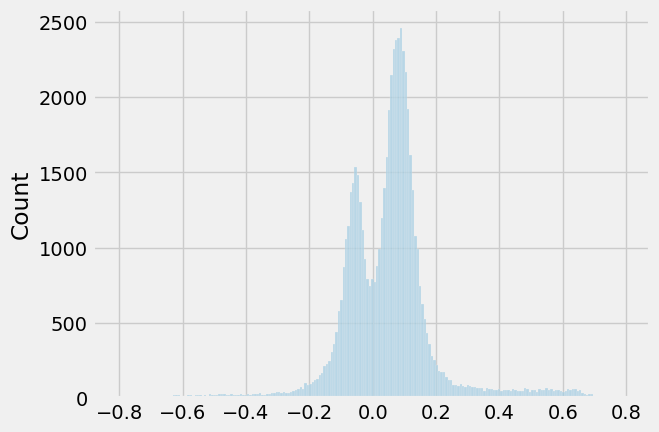

In [25]:
sns.histplot(uplift_s)

Uplift Curve


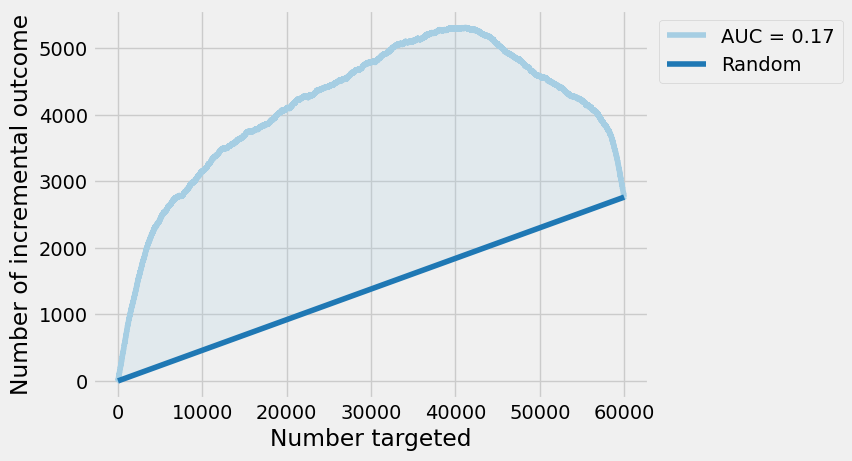

Metrics


,model
uplift_at_10,0.437733
uplift_at_30,0.215992
qini,0.244750
auuc,0.168685


Fact Predict
Fact Predict Graph


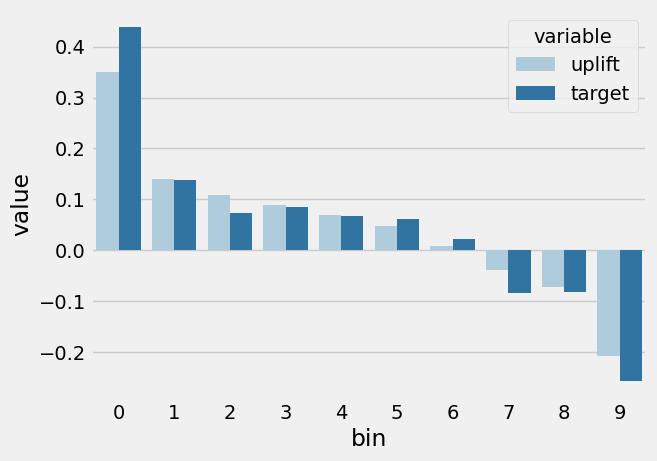

Binarized Fact


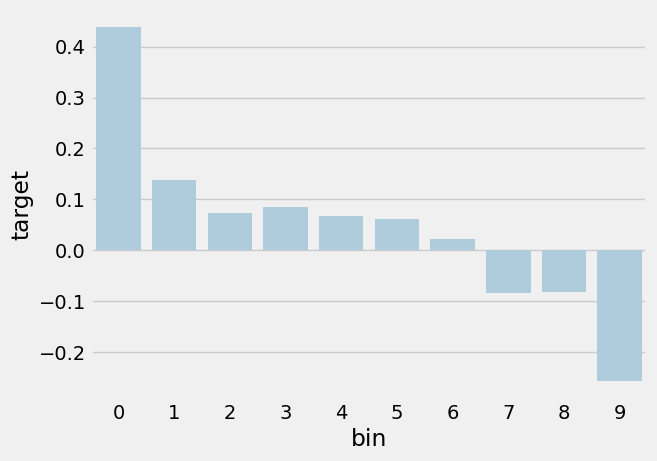

In [26]:
show_results(df=data.loc[val_idx], target_col=target_col, uplift=uplift_s, treatment_col=treatment_col)

In [27]:
overall_results['slearner'] = get_metrics_from_results({'slearner': uplift_s}, data.loc[val_idx], target_col, treatment_col).to_dict()['slearner']
f_p = fact_predict(data.loc[val_idx, target_col], uplift_s, data.loc[val_idx, treatment_col])
overall_results['slearner']['fact_predict'] = -((f_p['uplift'] - f_p['target'])**2).sum()

## Vanilla

In [28]:
slearner_vanilla = LGBMClassifier(**best_params_s)
slearner_vanilla.fit(data.loc[train_idx, selected_features+[treatment_col]], data.loc[train_idx, target_col])

LGBMClassifier(bagging_fraction=0.5249125336663966, bagging_freq=2,
               feature_fraction=0.9180258773516364,
               lambda_l1=1.5710553601788224, lambda_l2=1.4272057359321316e-05,
               learning_rate=0.05887397980783336, max_depth=9,
               min_child_samples=17, n_estimators=395, num_leaves=123,
               random_state=777, verbose=-100)

In [29]:
preds_s_t = slearner_vanilla.predict_proba(data.loc[val_idx, selected_features].assign(treatment_col=1))[:, 1]
preds_s_c = slearner_vanilla.predict_proba(data.loc[val_idx, selected_features].assign(treatment_col=0))[:, 1]

uplift_s_vanilla = preds_s_t - preds_s_c

In [30]:
uplift_s_vanilla

array([ 0.48399898, -0.01129624,  0.05380164, ...,  0.01131167,
        0.09137346,  0.10057971])

<Axes: ylabel='Count'>

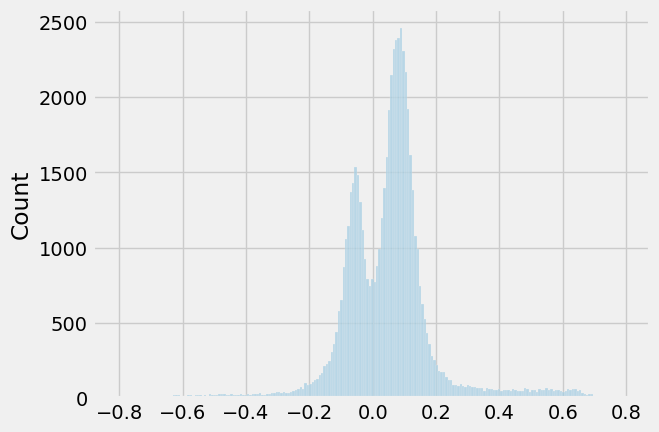

In [31]:
sns.histplot(uplift_s_vanilla)

Uplift Curve


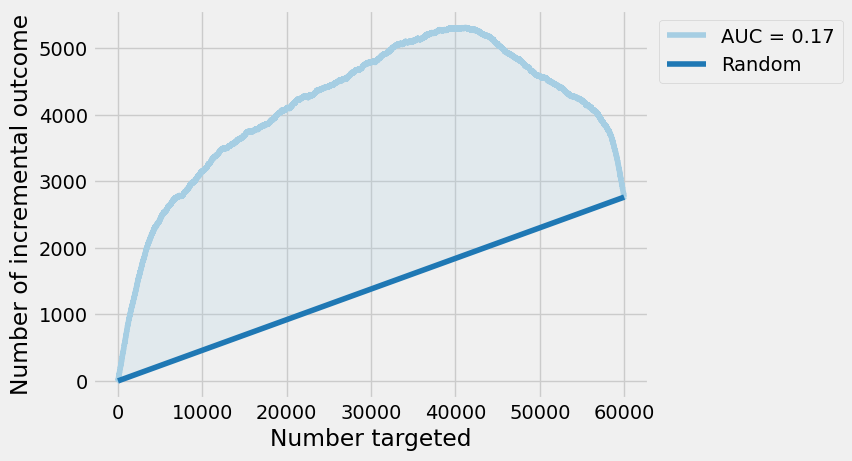

Metrics


,model
uplift_at_10,0.437733
uplift_at_30,0.215992
qini,0.244750
auuc,0.168685


Fact Predict
Fact Predict Graph


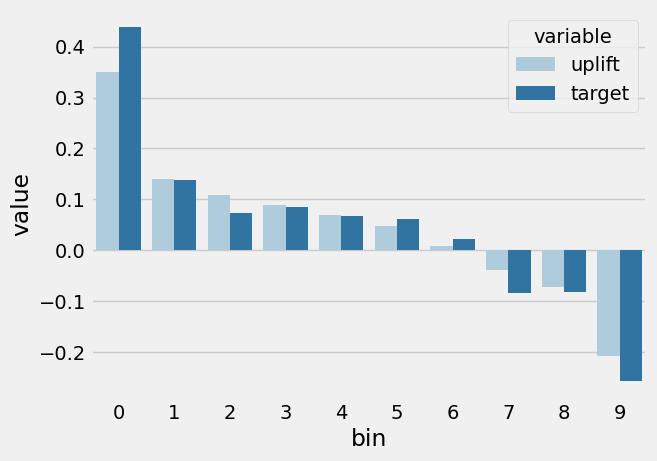

Binarized Fact


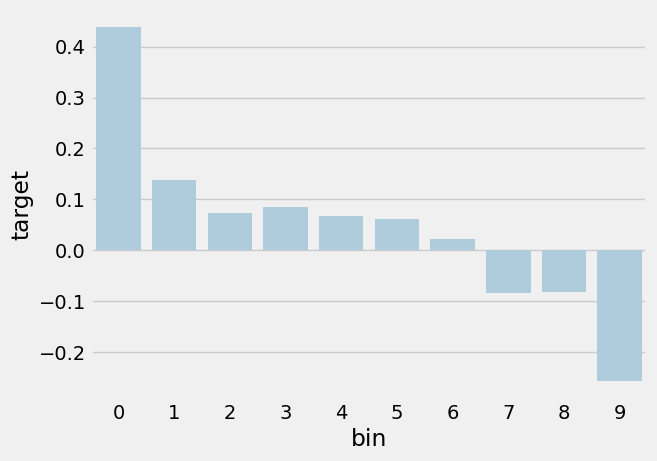

In [32]:
show_results(df=data.loc[val_idx], target_col=target_col, uplift=uplift_s_vanilla, treatment_col=treatment_col)

In [33]:
slearner_vanilla.feature_importances_

array([1493, 1323,  850, 1110, 1563, 1414, 1947, 1169, 1553, 1055, 1433,
       1614, 1138, 1797,  998, 1299, 1789, 1052, 1390, 1333, 1370, 1554,
       1608, 1309, 1229, 1898, 1049, 1167, 1760, 1205, 1470, 1370, 1788,
       1356,  737])

# T-Learner, DDR

https://www.uplift-modeling.com/en/latest/user_guide/models/two_models.html

In [34]:
# def objective(trial):
#     params_t = {
#         'lambda_l1': trial.suggest_float('lambda_l1_t', 1e-8, 10.0, log=True),
#         'lambda_l2': trial.suggest_float('lambda_l2_t', 1e-8, 10.0, log=True),
#         'num_leaves': trial.suggest_int('num_leaves_t', 2, 256),
#         'max_depth': trial.suggest_int('max_depth_t', 2, 16),
#         'n_estimators': trial.suggest_int('n_estimators_t', 100, 1500),
#         'learning_rate': trial.suggest_float('learning_rate_t', 0.01, 0.2),
#         'feature_fraction': trial.suggest_float('feature_fraction_t', 0.4, 1.0),
#         'bagging_fraction': trial.suggest_float('bagging_fraction_t', 0.4, 1.0),
#         'bagging_freq': trial.suggest_int('bagging_freq_t', 1, 7),
#         'min_child_samples': trial.suggest_int('min_child_samples_t', 5, 100),
#         'class_weight': trial.suggest_categorical('class_weight_t', ['balanced', None]),
#         'verbose': -100,
#         'random_state': SEED
#     }

#     params_c= {
#         'lambda_l1': trial.suggest_float('lambda_l1_c', 1e-8, 10.0, log=True),
#         'lambda_l2': trial.suggest_float('lambda_l2_c', 1e-8, 10.0, log=True),
#         'num_leaves': trial.suggest_int('num_leaves_c', 2, 256),
#         'max_depth': trial.suggest_int('max_depth_c', 2, 16),
#         'n_estimators': trial.suggest_int('n_estimators_c', 100, 1500),
#         'learning_rate': trial.suggest_float('learning_rate_c', 0.01, 0.2),
#         'feature_fraction': trial.suggest_float('feature_fraction_c', 0.4, 1.0),
#         'bagging_fraction': trial.suggest_float('bagging_fraction_c', 0.4, 1.0),
#         'bagging_freq': trial.suggest_int('bagging_freq_c', 1, 7),
#         'min_child_samples': trial.suggest_int('min_child_samples_c', 5, 100),
#         'class_weight': trial.suggest_categorical('class_weight_c', ['balanced', None]),
#         'verbose': -100,
#         'random_state': SEED
#     }

#     method = trial.suggest_categorical('method', ['vanilla', 'ddr_control', 'ddr_treatment'])

#     estimator_t = LGBMClassifier(**params_t)
#     estimator_c = LGBMClassifier(**params_c)
#     model = TwoModels(estimator_trmnt=estimator_t, estimator_ctrl=estimator_c, method=method)
#     model.fit(data.loc[train_idx, selected_features], target.loc[train_idx], treatment.loc[train_idx].map({'treatment': 1, 'control': 0}))

#     uplift_val = model.predict(data.loc[val_idx, selected_features])
#     if all(uplift_val == 0):
#         raise optuna.TrialPruned()
        
#     score = qini_auc_score(y_true=target.loc[val_idx], uplift=uplift_val, treatment=treatment.loc[val_idx].map({'treatment': 1, 'control': 0}))
#     if score < 0 :
#         raise optuna.TrialPruned()
    
#     return score

# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=50)

# best_params_t = study.best_params
# best_params_t['verbose'] = -100
# best_params_t['random_state'] = SEED

# joblib.dump(best_params_t, './cache/best_params_t.pkl')
best_params_t = joblib.load('./cache/best_params_t.pkl')

In [35]:
best_params_t_tr = {'verbose': -100, 'random_state': SEED}
best_params_t_c = {'verbose': -100, 'random_state': SEED}
method_t = best_params_t['method']

for param, value in best_params_t.items():
    if param.endswith('_t'):
        best_params_t_tr[param] = value
    elif param.endswith('_c'):
        best_params_t_c[param] = value

best_params_t_tr, best_params_t_c

({'verbose': -100,
  'random_state': 777,
  'lambda_l1_t': 9.573886352966143e-05,
  'lambda_l2_t': 0.18510155763777913,
  'num_leaves_t': 256,
  'max_depth_t': 12,
  'n_estimators_t': 861,
  'learning_rate_t': 0.017922111556218326,
  'feature_fraction_t': 0.8326993555705663,
  'bagging_fraction_t': 0.6606970849905023,
  'bagging_freq_t': 7,
  'min_child_samples_t': 66,
  'class_weight_t': None},
 {'verbose': -100,
  'random_state': 777,
  'lambda_l1_c': 9.548363207528395e-05,
  'lambda_l2_c': 1.187755375480853e-07,
  'num_leaves_c': 29,
  'max_depth_c': 8,
  'n_estimators_c': 872,
  'learning_rate_c': 0.1064553610207556,
  'feature_fraction_c': 0.6101064558661319,
  'bagging_fraction_c': 0.90167969664616,
  'bagging_freq_c': 5,
  'min_child_samples_c': 58,
  'class_weight_c': None})

In [36]:
%%time

estimator_t = LGBMClassifier(**best_params_t_tr)
estimator_c = LGBMClassifier(**best_params_t_c)

tlearner = TwoModels(estimator_trmnt=estimator_t, estimator_ctrl=estimator_c, method=method_t)
tlearner.fit(data.loc[train_idx, selected_features], target.loc[train_idx], treatment.loc[train_idx].map({'treatment': 1, 'control': 0}))

uplift_t = tlearner.predict(data.loc[val_idx, selected_features])

CPU times: total: 8.97 s
Wall time: 2.34 s


<Axes: ylabel='Count'>

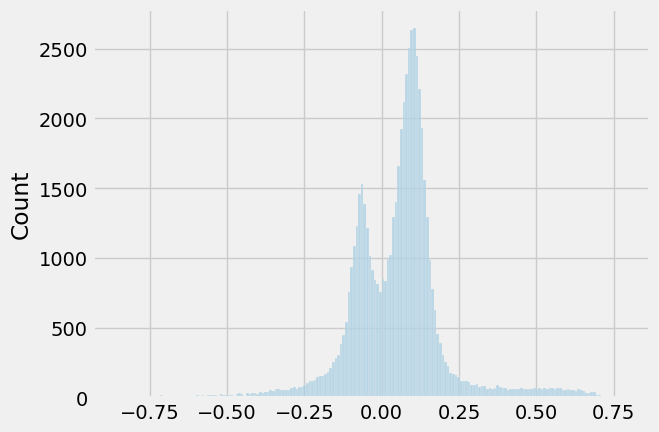

In [37]:
sns.histplot(uplift_t)

Uplift Curve


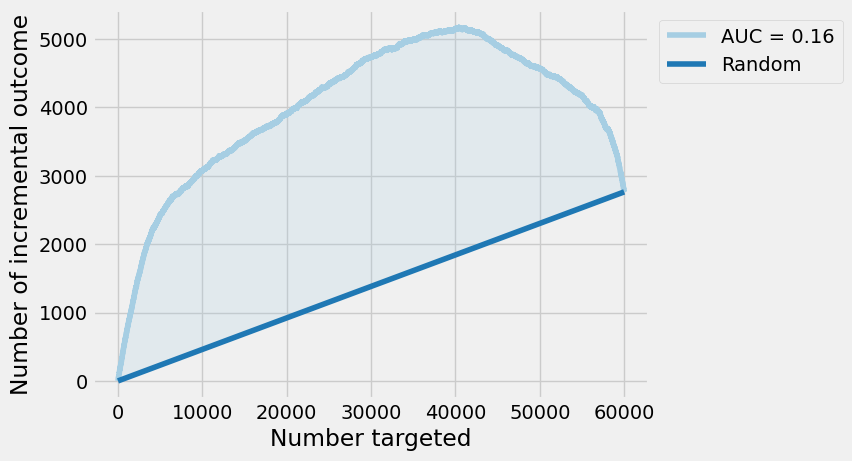

Metrics


,model
uplift_at_10,0.434063
uplift_at_30,0.207211
qini,0.235222
auuc,0.162389


Fact Predict
Fact Predict Graph


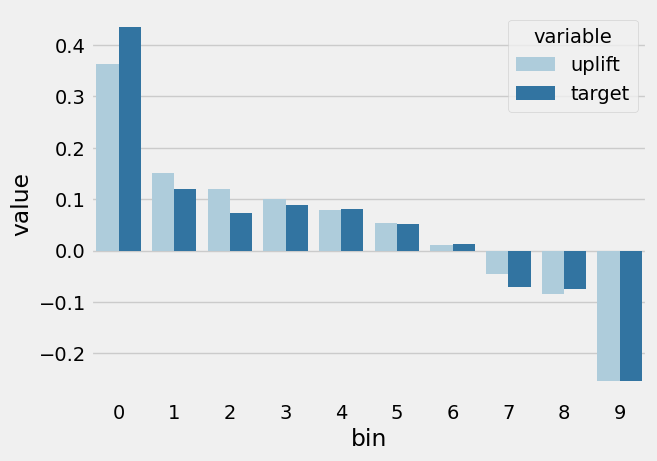

Binarized Fact


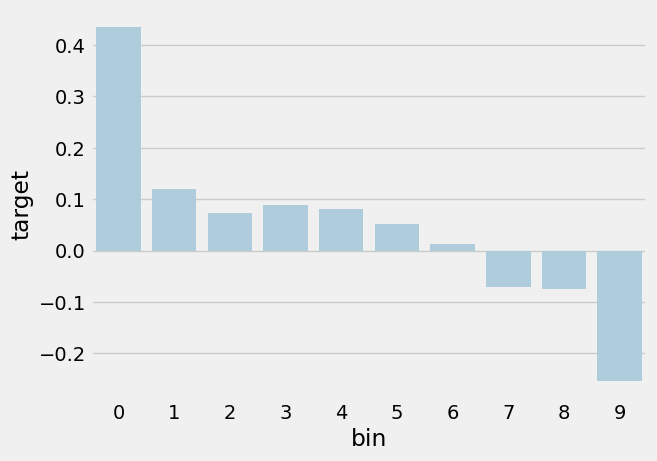

In [38]:
show_results(df=data.loc[val_idx], target_col=target_col, uplift=uplift_t, treatment_col=treatment_col)

In [39]:
overall_results['tlearner'] = get_metrics_from_results({'tlearner': uplift_t}, data.loc[val_idx], target_col, treatment_col).to_dict()['tlearner']
f_p = fact_predict(data.loc[val_idx, target_col], uplift_t, data.loc[val_idx, treatment_col])
overall_results['tlearner']['fact_predict'] = -((f_p['uplift'] - f_p['target'])**2).sum()

## Vanilla

In [40]:
x_train = data.loc[train_idx]
x_train_c = x_train[x_train[treatment_col] == 0][selected_features]
x_train_t = x_train[x_train[treatment_col] == 1][selected_features]

y_train = target.loc[train_idx]
y_train_c = y_train.loc[x_train_c.index]
y_train_t = y_train.loc[x_train_t.index]

In [41]:
%%time

estimator_t = LGBMClassifier(**best_params_t_tr)
estimator_c = LGBMClassifier(**best_params_t_c)

estimator_c.fit(x_train_c, y_train_c)
estimator_t.fit(x_train_t, y_train_t)

uplift_t_vanilla = estimator_t.predict_proba(data.loc[val_idx, selected_features])[:, 1] \
- estimator_c.predict_proba(data.loc[val_idx, selected_features])[:, 1]

CPU times: total: 9.14 s
Wall time: 2.18 s


<Axes: ylabel='Count'>

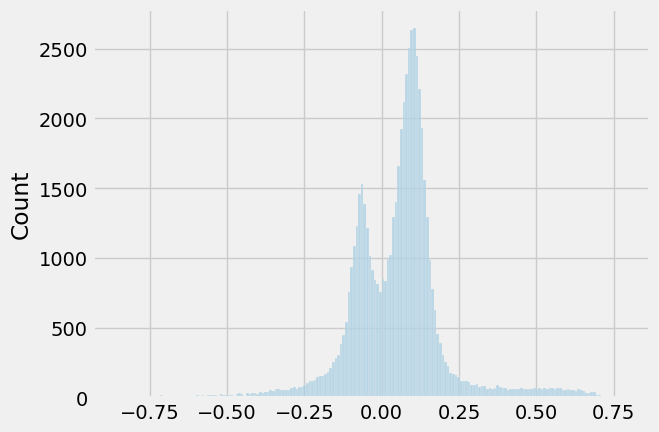

In [42]:
sns.histplot(uplift_t_vanilla)

Uplift Curve


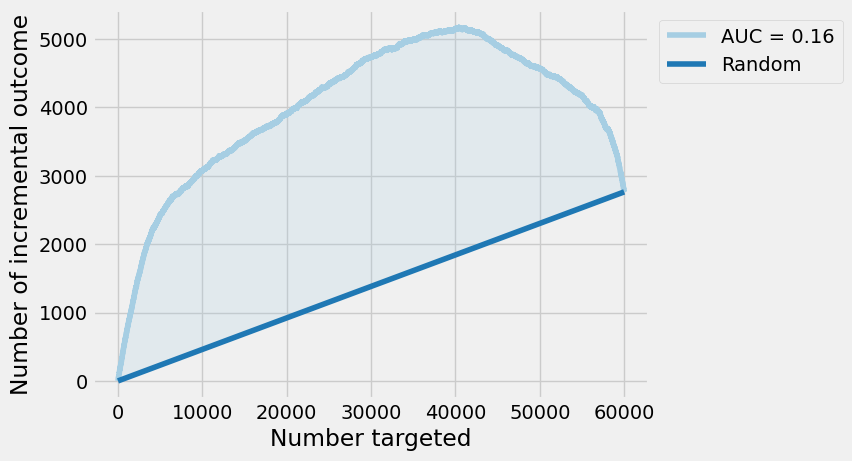

Metrics


,model
uplift_at_10,0.434063
uplift_at_30,0.207211
qini,0.235222
auuc,0.162389


Fact Predict
Fact Predict Graph


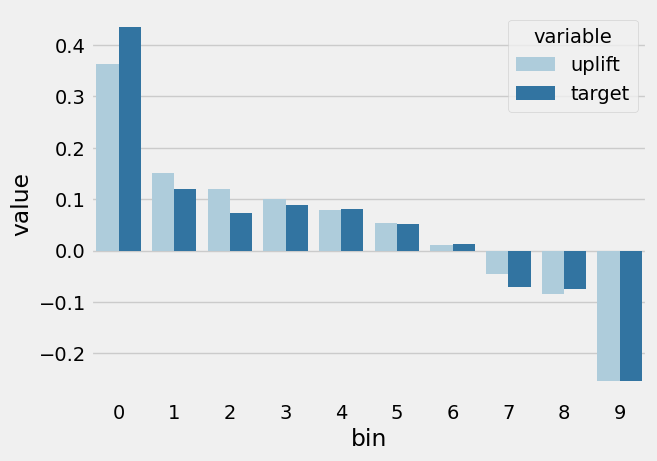

Binarized Fact


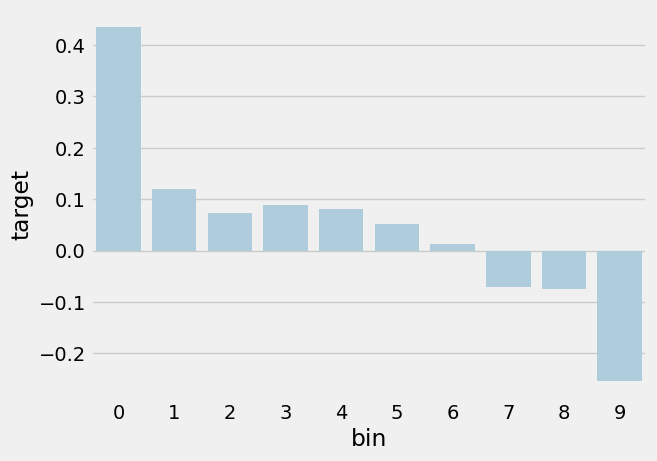

In [43]:
show_results(df=data.loc[val_idx], target_col=target_col, uplift=uplift_t_vanilla, treatment_col=treatment_col)

## DDR Control

In [44]:
%%time

# control
x_train = data.loc[train_idx]
x_train_c = x_train[x_train[treatment_col] == 0][selected_features]

y_train = target.loc[train_idx]
y_train_c = y_train.loc[x_train_c.index]

estimator_c = LGBMClassifier(**best_params_t_c)
estimator_c.fit(x_train_c, y_train_c)

CPU times: total: 3.64 s
Wall time: 1.1 s


LGBMClassifier(bagging_fraction_c=0.90167969664616, bagging_freq_c=5,
               class_weight_c=None, feature_fraction_c=0.6101064558661319,
               lambda_l1_c=9.548363207528395e-05,
               lambda_l2_c=1.187755375480853e-07,
               learning_rate_c=0.1064553610207556, max_depth_c=8,
               min_child_samples_c=58, n_estimators_c=872, num_leaves_c=29,
               random_state=777, verbose=-100)

In [45]:
%%time

# treatment
x_train = data.loc[train_idx]
x_train_t = x_train[x_train[treatment_col] == 1][selected_features]
x_train_t = x_train_t.assign(c_preds=estimator_c.predict_proba(x_train_t)[:, 1])

y_train = target.loc[train_idx]
y_train_t = y_train.loc[x_train_t.index]

estimator_t = LGBMClassifier(**best_params_t_tr)
estimator_t.fit(x_train_t, y_train_t)

CPU times: total: 5.48 s
Wall time: 1.37 s


LGBMClassifier(bagging_fraction_t=0.6606970849905023, bagging_freq_t=7,
               class_weight_t=None, feature_fraction_t=0.8326993555705663,
               lambda_l1_t=9.573886352966143e-05,
               lambda_l2_t=0.18510155763777913,
               learning_rate_t=0.017922111556218326, max_depth_t=12,
               min_child_samples_t=66, n_estimators_t=861, num_leaves_t=256,
               random_state=777, verbose=-100)

In [46]:
control_preds = estimator_c.predict_proba(data.loc[val_idx, selected_features])[:, 1]
treatment_preds = estimator_t.predict_proba(data.loc[val_idx, selected_features].assign(c_preds=control_preds))[:, 1]

uplift_t_vanilla_ddr_control = treatment_preds - control_preds

<Axes: ylabel='Count'>

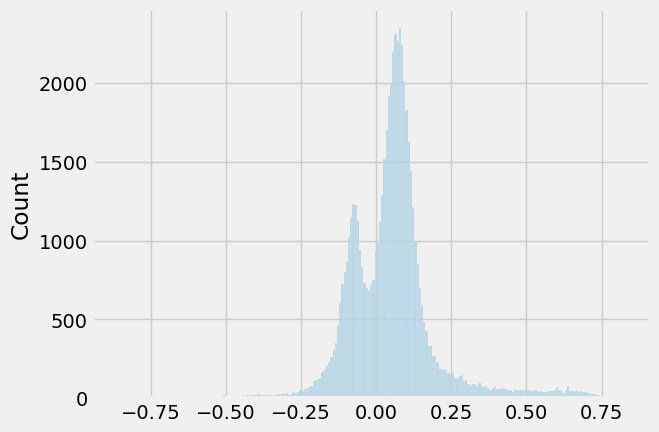

In [47]:
sns.histplot(uplift_t_vanilla_ddr_control)

Uplift Curve


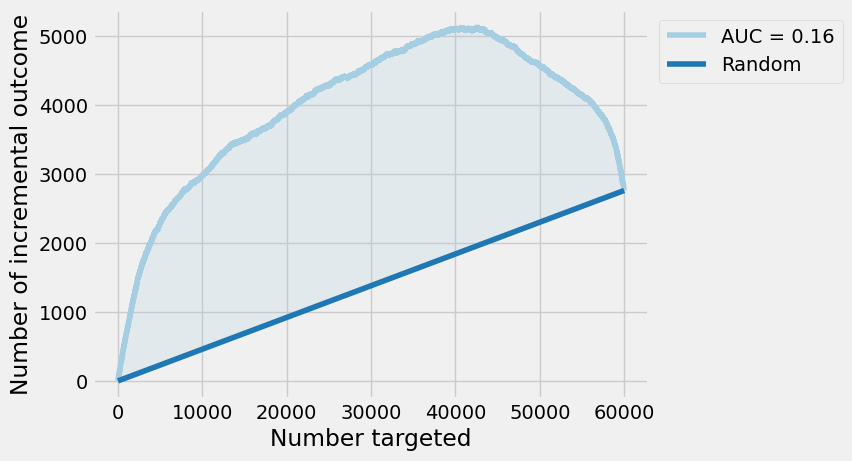

Metrics


,model
uplift_at_10,0.414912
uplift_at_30,0.205745
qini,0.232452
auuc,0.160249


Fact Predict
Fact Predict Graph


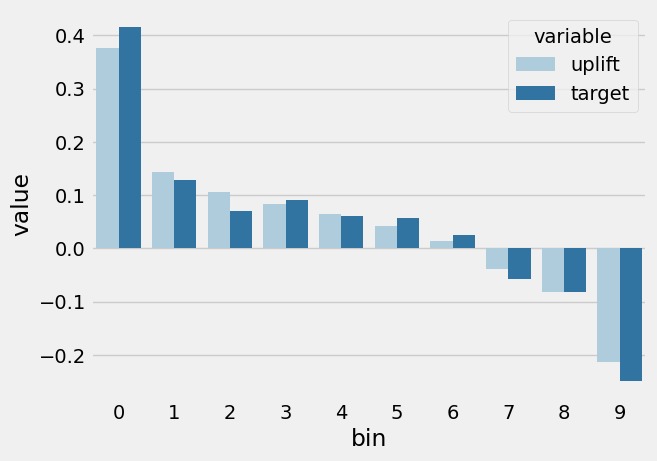

Binarized Fact


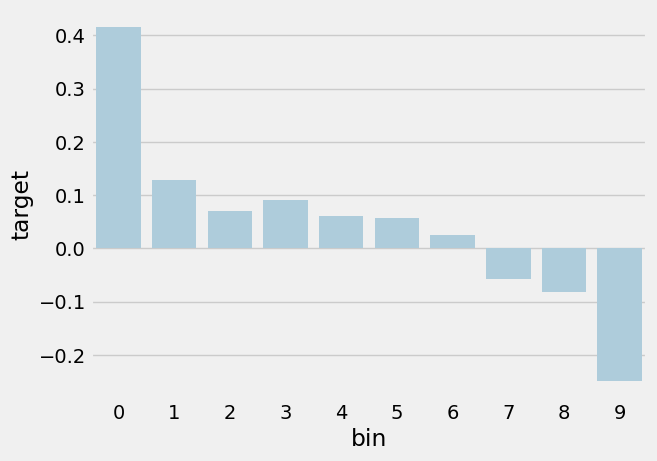

In [48]:
show_results(df=data.loc[val_idx], target_col=target_col, uplift=uplift_t_vanilla_ddr_control, treatment_col=treatment_col)

# Transformed Outcome

$y_{trans}$ = $y*\frac{T}{P(T=1|X)}$ - $y*\frac{1-T}{P(T=0|X)}$

https://www.uplift-modeling.com/en/latest/user_guide/models/transformed_outcome.html

In [49]:
# def objective(trial):
#     params = {
#         'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
#         'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
#         'num_leaves': trial.suggest_int('num_leaves', 2, 256),
#         'max_depth': trial.suggest_int('max_depth', 2, 16),
#         'n_estimators': trial.suggest_int('n_estimators', 100, 1500),
#         'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
#         'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
#         'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
#         'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
#         'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
#         # 'class_weight': trial.suggest_categorical('class_weight', ['balanced', None]),
#         'verbose': -100,
#         'random_state': SEED
#     }

#     estimator = LGBMRegressor(**params)

#     model = ClassTransformationReg(
#         estimator=estimator,
#         propensity_estimator=LGBMClassifier(max_depth=5, n_estimators=500, verbose=-100, random_state=SEED))
    
#     model.fit(data.loc[train_idx, selected_features], target.loc[train_idx], treatment.loc[train_idx].map({'treatment': 1, 'control': 0}))

#     uplift_val = model.predict(data.loc[val_idx, selected_features])
#     if all(uplift_val == 0):
#         raise optuna.TrialPruned()
        
#     score = qini_auc_score(y_true=target.loc[val_idx], uplift=uplift_val, treatment=treatment.loc[val_idx].map({'treatment': 1, 'control': 0}))
#     if score < 0 :
#         raise optuna.TrialPruned()
    
#     return score

# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=50)

# best_params_to = study.best_params
# best_params_to['verbose'] = -100
# best_params_to['random_state'] = SEED

# joblib.dump(best_params_to, './cache/best_params_to.pkl')
best_params_to = joblib.load('./cache/best_params_to.pkl')

In [50]:
%%time

estimator = LGBMRegressor(**best_params_to)

transout = ClassTransformationReg(
    estimator=estimator,
    propensity_estimator=LGBMClassifier(max_depth=5, n_estimators=500, verbose=-100, random_state=SEED))

transout.fit(data.loc[train_idx, selected_features], target.loc[train_idx], treatment.loc[train_idx].map({'treatment': 1, 'control': 0}))

uplift_to = transout.predict(data.loc[val_idx, selected_features])

CPU times: total: 1min 35s
Wall time: 21.9 s


<Axes: ylabel='Count'>

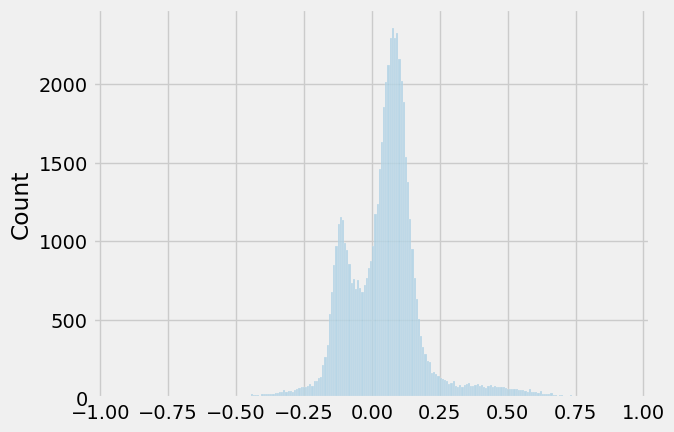

In [51]:
sns.histplot(uplift_to)

Uplift Curve


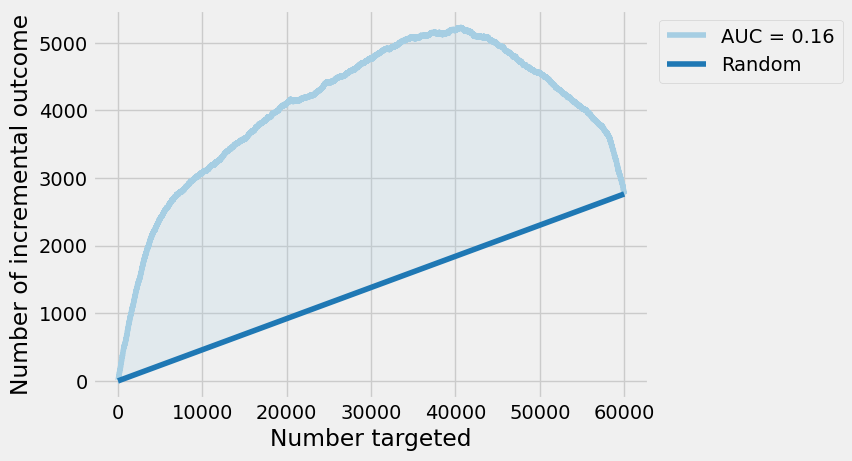

Metrics


,model
uplift_at_10,0.432040
uplift_at_30,0.216472
qini,0.237281
auuc,0.164028


Fact Predict
Fact Predict Graph


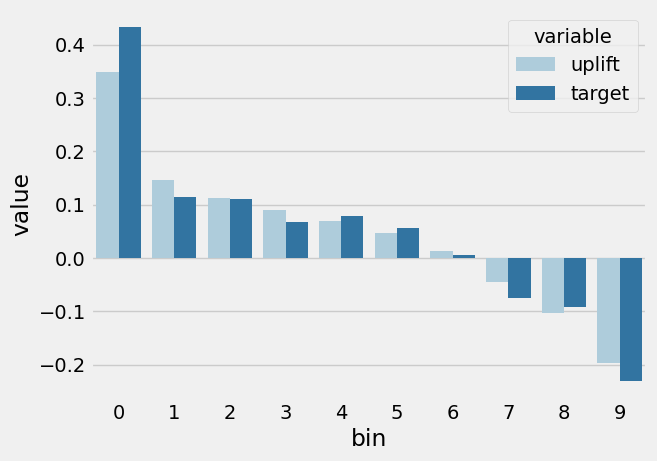

Binarized Fact


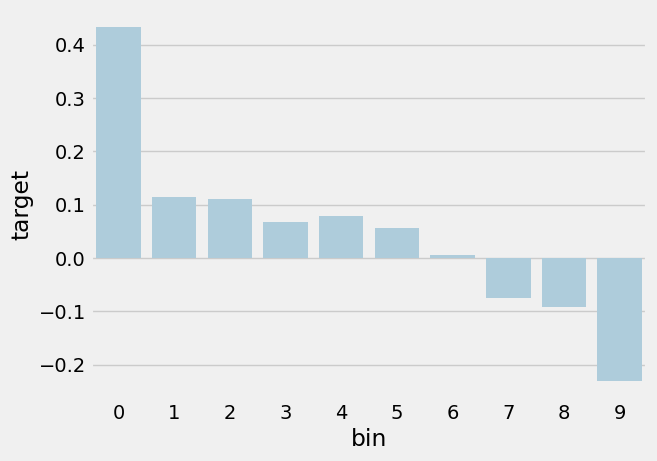

In [52]:
show_results(df=data.loc[val_idx], target_col=target_col, uplift=uplift_to, treatment_col=treatment_col)

In [53]:
overall_results['transformed_outcome'] = get_metrics_from_results({'transformed_outcome': uplift_to}, data.loc[val_idx], target_col, treatment_col).to_dict()['transformed_outcome']
f_p = fact_predict(data.loc[val_idx, target_col], uplift_to, data.loc[val_idx, treatment_col])
overall_results['transformed_outcome']['fact_predict'] = -((f_p['uplift'] - f_p['target'])**2).sum()

## Vanilla

In [54]:
data.loc[train_idx, treatment_col].value_counts(normalize=True)

treatment
1    0.500648
0    0.499352
Name: proportion, dtype: float64

In [55]:
p_1, p_0 = data.loc[train_idx, treatment_col].value_counts(normalize=True).values

is_treated_train = data.loc[train_idx, treatment_col]
y_trans = data.loc[train_idx, target_col] * is_treated_train / p_1 - data.loc[train_idx, target_col] * (1-is_treated_train) / p_0

In [56]:
y_trans

364934    1.997412
95092     0.000000
507561    0.000000
185541    0.000000
446376    0.000000
            ...   
102321    1.997412
106071    0.000000
183206    0.000000
474683    0.000000
325735    0.000000
Length: 480000, dtype: float64

In [57]:
propensity_estimator = LGBMClassifier(max_depth=5, n_estimators=500, verbose=-100, random_state=SEED)
propensity_estimator.fit(data.loc[train_idx, selected_features], data.loc[train_idx, treatment_col])

LGBMClassifier(max_depth=5, n_estimators=500, random_state=777, verbose=-100)

In [58]:
propensity_estimator.predict_proba(data.loc[train_idx, selected_features])[:, 1]

array([0.47629853, 0.52055759, 0.52300707, ..., 0.49088891, 0.44417391,
       0.54641516])

In [59]:
transout.propensity_estimator.predict_proba(data.loc[train_idx, selected_features])[:, 1]

array([0.47629853, 0.52055759, 0.52300707, ..., 0.49088891, 0.44417391,
       0.54641516])

In [60]:
propensity = propensity_estimator.predict_proba(data.loc[train_idx, selected_features])

y_trans = data.loc[train_idx, target_col] * is_treated_train / propensity[:, 1] - data.loc[train_idx, target_col] * (1-is_treated_train) / propensity[:, 0]

In [61]:
data.loc[train_idx, target_col] * (data.loc[train_idx, treatment_col] - propensity[:, 1]) / (propensity[:, 1] * propensity[:, 0])

364934    2.099524
95092    -0.000000
507561    0.000000
185541    0.000000
446376   -0.000000
            ...   
102321    1.990948
106071    0.000000
183206    0.000000
474683   -0.000000
325735   -0.000000
Length: 480000, dtype: float64

In [62]:
%%time

transout_vanilla = LGBMRegressor(**best_params_to)
transout_vanilla.fit(data.loc[train_idx, selected_features], y_trans)

CPU times: total: 58.6 s
Wall time: 13.6 s


LGBMRegressor(bagging_fraction=0.6613761197220982, bagging_freq=7,
              feature_fraction=0.8238698473648789, lambda_l1=1.3686222203107126,
              lambda_l2=0.09812538336891717, learning_rate=0.011480199610411995,
              max_depth=15, min_child_samples=100, n_estimators=936,
              num_leaves=99, random_state=777, verbose=-100)

In [63]:
uplift_to_vanilla = transout_vanilla.predict(data.loc[val_idx, selected_features])

<Axes: ylabel='Count'>

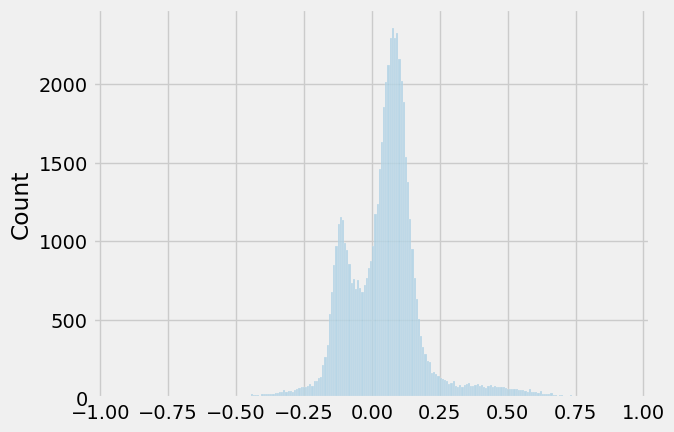

In [64]:
sns.histplot(uplift_to_vanilla)

Uplift Curve


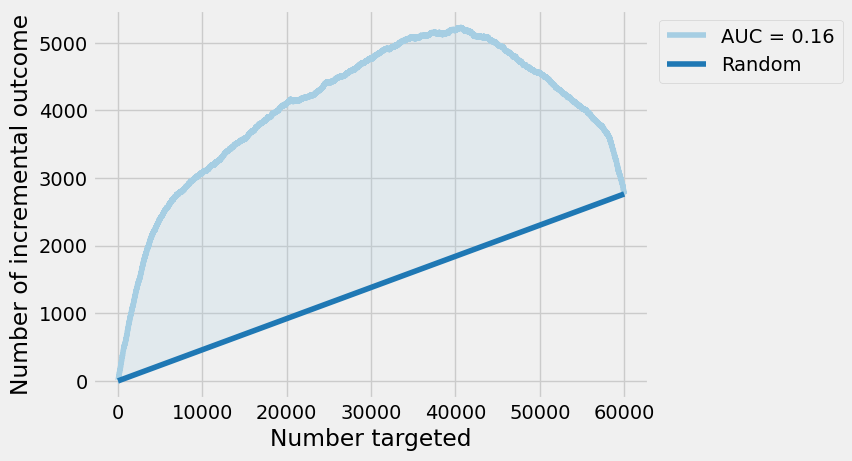

Metrics


,model
uplift_at_10,0.432040
uplift_at_30,0.216472
qini,0.237281
auuc,0.164028


Fact Predict
Fact Predict Graph


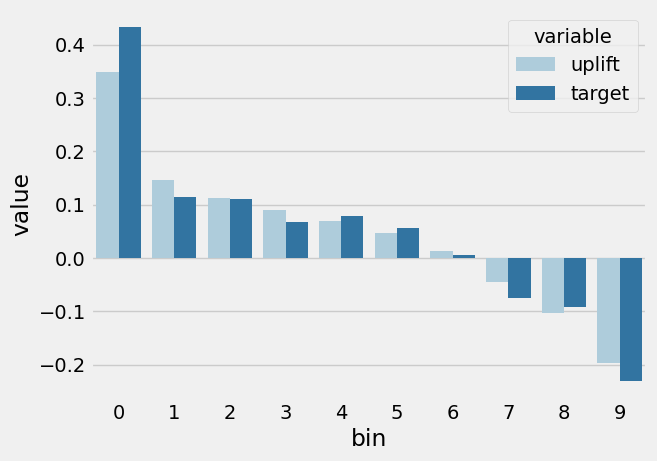

Binarized Fact


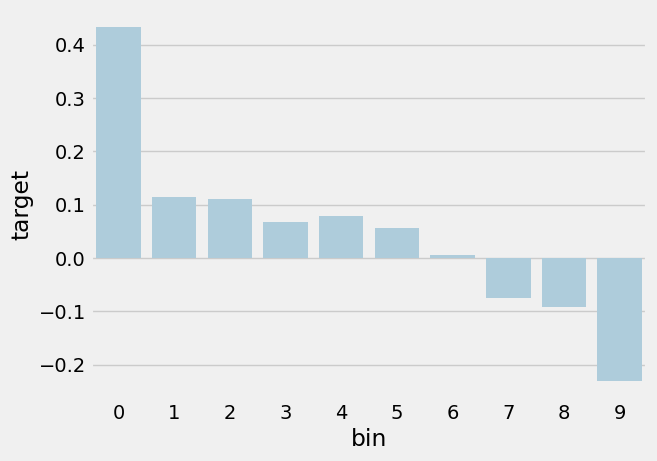

In [65]:
show_results(df=data.loc[val_idx], target_col=target_col, uplift=uplift_to_vanilla, treatment_col=treatment_col)

# X-Learner

In [66]:
%%time

xlearner = BaseXClassifier(
    control_outcome_learner=LGBMClassifier(max_depth=5, n_estimators=500, verbose=-100, random_state=SEED),
    treatment_outcome_learner=LGBMClassifier(max_depth=5, n_estimators=500, verbose=-100, random_state=SEED),
    control_effect_learner=LGBMRegressor(max_depth=5, n_estimators=500, verbose=-100, random_state=SEED),
    treatment_effect_learner=LGBMRegressor(max_depth=5, n_estimators=500, verbose=-100, random_state=SEED),
    control_name='control'
)

xlearner.fit(
    X=data.loc[train_idx, selected_features].values,
    y=target.loc[train_idx].values,
    treatment=treatment.loc[train_idx].values
)

uplift_xlearner = xlearner.predict(data.loc[val_idx, selected_features].values).ravel()

CPU times: total: 10min 21s
Wall time: 19min


In [67]:
uplift_xlearner

array([ 0.41243956, -0.10583172,  0.08473702, ..., -0.03847151,
        0.15350327,  0.12130097])

<Axes: ylabel='Count'>

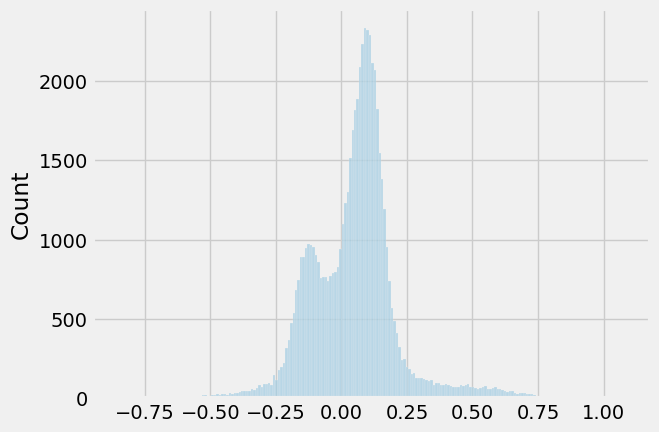

In [68]:
sns.histplot(uplift_xlearner)

Uplift Curve


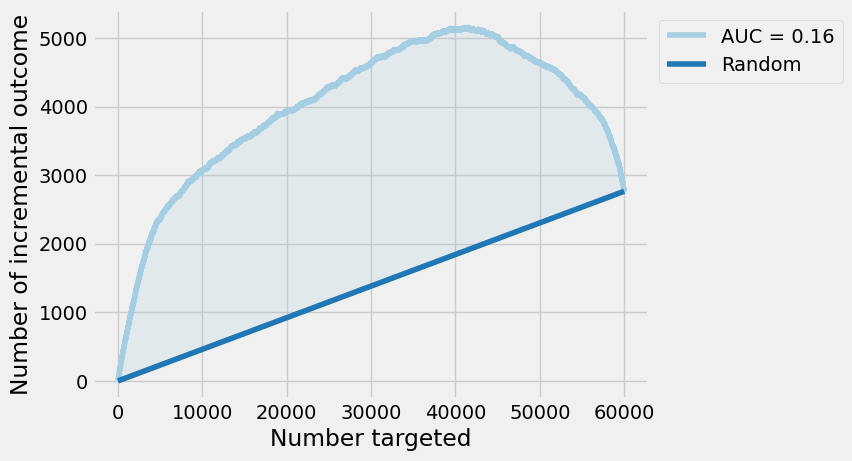

Metrics


,model
uplift_at_10,0.424587
uplift_at_30,0.209967
qini,0.234261
auuc,0.161527


Fact Predict
Fact Predict Graph


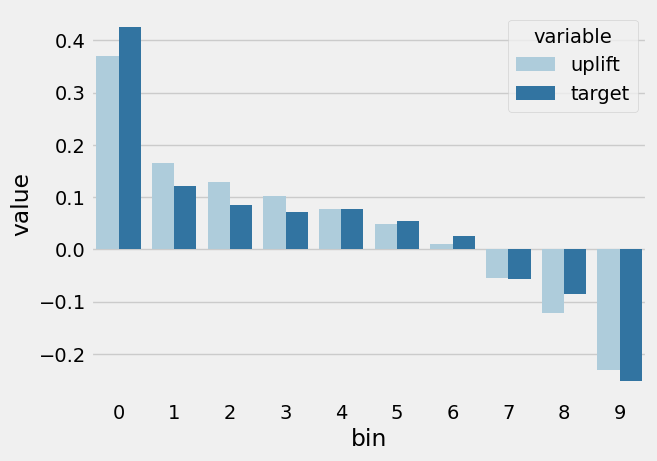

Binarized Fact


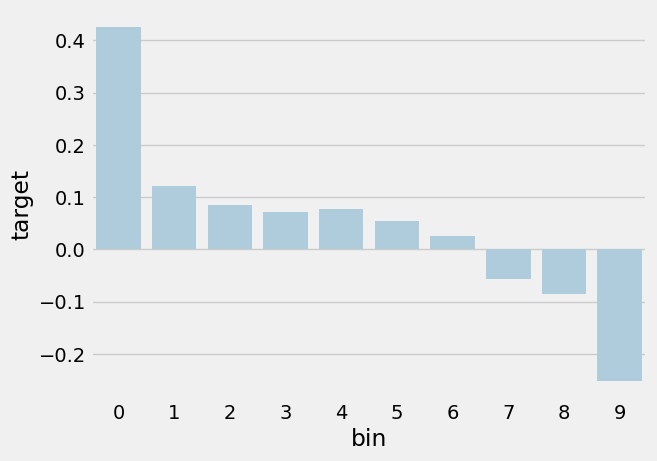

In [69]:
show_results(df=data.loc[val_idx], target_col=target_col, uplift=uplift_xlearner, treatment_col=treatment_col)

In [70]:
overall_results['xlearner'] = get_metrics_from_results({'xlearner': uplift_xlearner}, data.loc[val_idx], target_col, treatment_col).to_dict()['xlearner']
f_p = fact_predict(data.loc[val_idx, target_col], uplift_xlearner, data.loc[val_idx, treatment_col])
overall_results['xlearner']['fact_predict'] = -((f_p['uplift'] - f_p['target'])**2).sum()

# R-Learner

In [71]:
%%time

rlearner = BaseRClassifier(
    outcome_learner=LGBMClassifier(max_depth=5, n_estimators=500, verbose=-100, random_state=SEED),
    effect_learner=LGBMRegressor(max_depth=5, n_estimators=500, verbose=-100, random_state=SEED),
    control_name='control'
)

rlearner.fit(
    X=data.loc[train_idx, selected_features].values,
    y=target.loc[train_idx].values,
    treatment=treatment.loc[train_idx].values
)

uplift_rlearner = rlearner.predict(data.loc[val_idx, selected_features].values).ravel()

CPU times: total: 9min 53s
Wall time: 20min 58s


<Axes: ylabel='Count'>

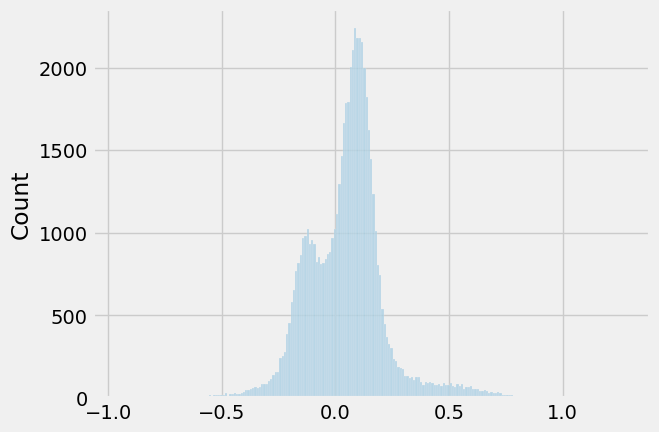

In [72]:
sns.histplot(uplift_rlearner)

Uplift Curve


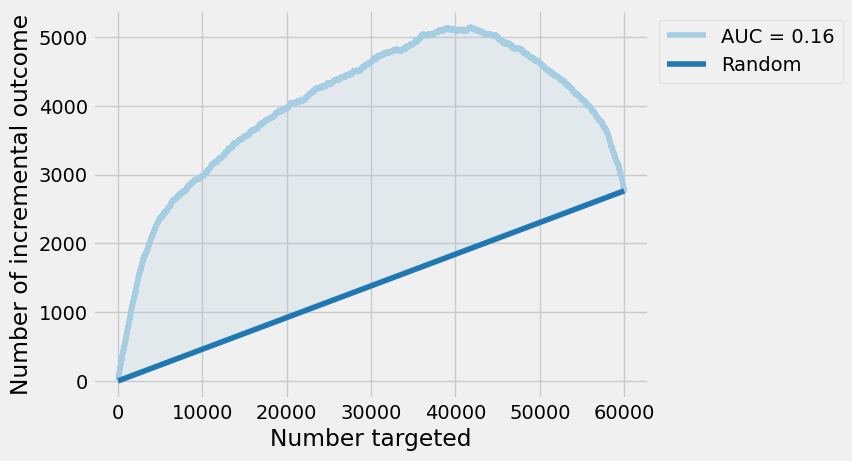

Metrics


,model
uplift_at_10,0.419454
uplift_at_30,0.211757
qini,0.233480
auuc,0.161261


Fact Predict
Fact Predict Graph


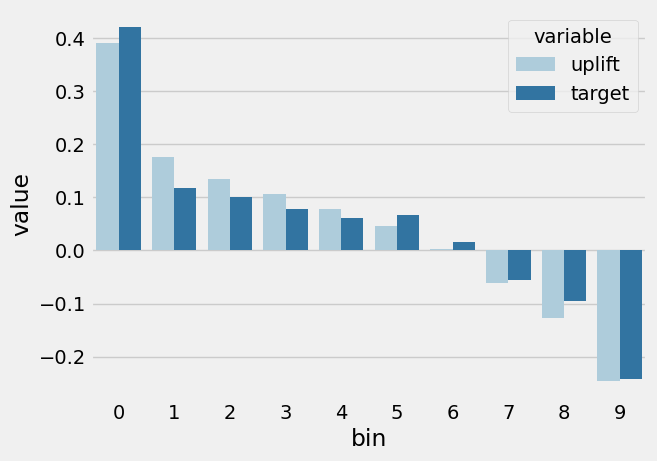

Binarized Fact


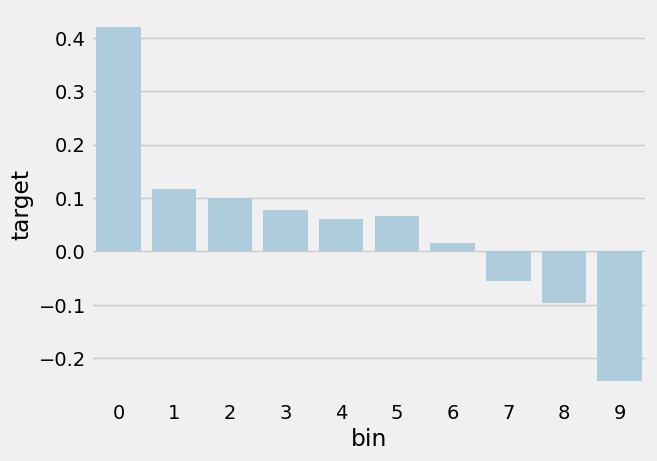

In [73]:
show_results(df=data.loc[val_idx], target_col=target_col, uplift=uplift_rlearner, treatment_col=treatment_col)

In [74]:
overall_results['rlearner'] = get_metrics_from_results({'rlearner': uplift_rlearner}, data.loc[val_idx], target_col, treatment_col).to_dict()['rlearner']
f_p = fact_predict(data.loc[val_idx, target_col], uplift_rlearner, data.loc[val_idx, treatment_col])
overall_results['rlearner']['fact_predict'] = -((f_p['uplift'] - f_p['target'])**2).sum()

# Uplift Forest

In [75]:
# def objective(trial):
#     params = {
#         'control_name': 'control',
#         'max_depth': trial.suggest_int('max_depth', 2, 16),
#         'n_estimators': trial.suggest_int('n_estimators', 5, 30),
#         'n_reg': trial.suggest_int('n_reg', 5, 50),
#         'max_features': trial.suggest_int('max_features', 5, 50),
#         'min_samples_leaf': trial.suggest_int('min_samples_leaf', 100, 2000),
#         'min_samples_treatment': trial.suggest_int('min_samples_treatment', 10, 500),
#         'evaluationFunction': trial.suggest_categorical('evaluationFunction', ['KL', 'ED', 'Chi', 'CTS', 'DDP', 'IT', 'CIT', 'IDDP']),
#         'normalization': trial.suggest_categorical('normalization', [True, False]),
#         'honesty': trial.suggest_categorical('honesty', [True, False]),
#         'random_state': SEED,
#         'n_jobs': -1
#     }

#     if params['honesty']:
#         params['estimation_sample_size'] = trial.suggest_float('estimation_sample_size', 0.1, 1.)

#     model = UpliftRandomForestClassifier(**params)
    
#     model.fit(
#         X=data.loc[train_idx, selected_features].values,
#         y=target.loc[train_idx].values,
#         treatment=treatment.loc[train_idx].values
#     )

#     uplift_val = model.predict(data.loc[val_idx, selected_features].values).ravel()
#     if all(uplift_val == 0):
#         raise optuna.TrialPruned()
        
#     score = qini_auc_score(y_true=target.loc[val_idx], uplift=uplift_val, treatment=treatment.loc[val_idx].map({'treatment': 1, 'control': 0}))
#     if score < 0 :
#         raise optuna.TrialPruned()
    
#     return score

# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=50)

# best_params_forest = study.best_params
# best_params_forest['control_name'] = 'control'
# best_params_forest['random_state'] = SEED

# joblib.dump(best_params_forest, './cache/best_params_forest.pkl')
best_params_forest = joblib.load('./cache/best_params_forest.pkl')

In [76]:
%%time

forest = UpliftRandomForestClassifier(**best_params_forest, n_jobs=1)
    
forest.fit(
    X=data.loc[train_idx, selected_features].values,
    y=target.loc[train_idx].values,
    treatment=treatment.loc[train_idx].values
)

uplift_forest = forest.predict(data.loc[val_idx, selected_features].values).ravel()

CPU times: total: 5min 15s
Wall time: 11min 48s


<Axes: ylabel='Count'>

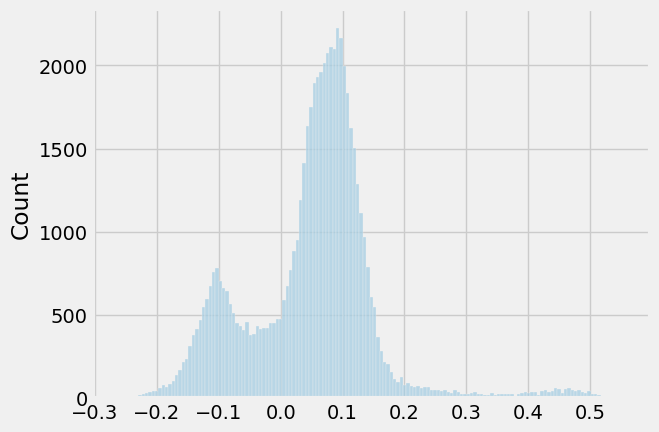

In [77]:
sns.histplot(uplift_forest)

Uplift Curve


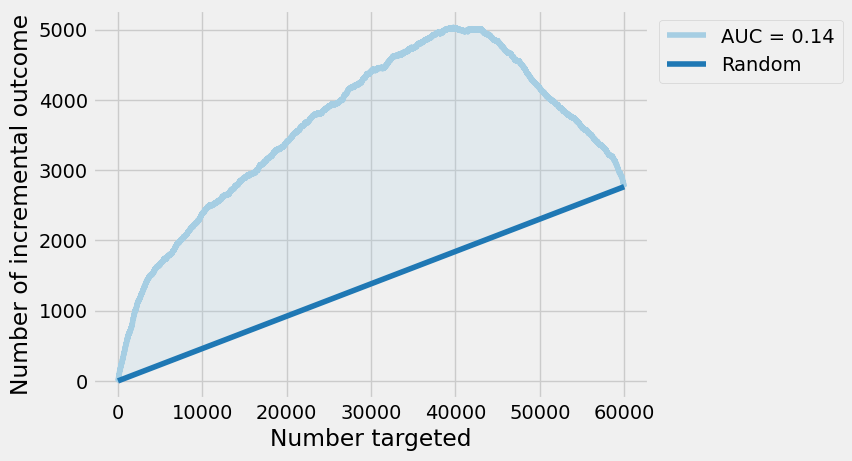

Metrics


,model
uplift_at_10,0.296930
uplift_at_30,0.176938
qini,0.198035
auuc,0.136462


Fact Predict
Fact Predict Graph


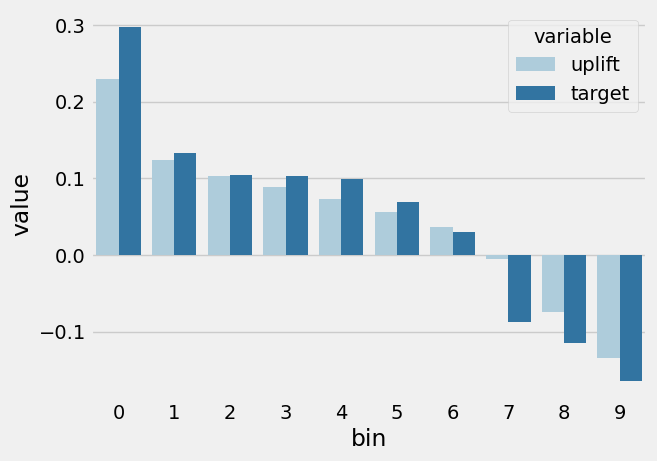

Binarized Fact


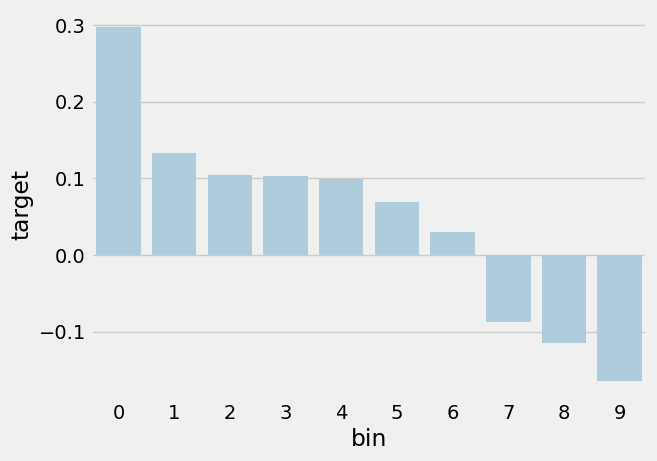

In [78]:
show_results(df=data.loc[val_idx], target_col=target_col, uplift=uplift_forest, treatment_col=treatment_col)

In [79]:
overall_results['forest'] = get_metrics_from_results({'forest': uplift_forest}, data.loc[val_idx], target_col, treatment_col).to_dict()['forest']
f_p = fact_predict(data.loc[val_idx, target_col], uplift_forest, data.loc[val_idx, treatment_col])
overall_results['forest']['fact_predict'] = -((f_p['uplift'] - f_p['target'])**2).sum()

In [81]:
pd.DataFrame(overall_results).style.highlight_max(axis=1, color='green')  

,slearner,tlearner,transformed_outcome,xlearner,rlearner,forest
uplift_at_10,0.437733,0.434063,0.432040,0.424587,0.419454,0.296930
uplift_at_30,0.215992,0.207211,0.216472,0.209967,0.211757,0.176938
qini,0.244750,0.235222,0.237281,0.234261,0.233480,0.198035
auuc,0.168685,0.162389,0.164028,0.161527,0.161261,0.136462
fact_predict,-0.013881,-0.009219,-0.010880,-0.009835,-0.008118,-0.014934


## В Итоге лучшим оказался S-Learner, по разнице факт-прогноз лучше T-Learner